Once cointegrated pairs have been selected, use this script to predict their spread with linear regression

In [14]:
%store -r cointegrated_stocks industry_data_dict

In [22]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS

import yfinance as yf
import seaborn
import matplotlib.pyplot as plt

import scipy.stats as stats
cointegrated_stocks

[]

In [23]:
def get_timestamps(symbol:str):
    return list(map(lambda x: x.split(' ')[0] ,industry_data_dict[symbol].index.strftime('%Y-%m-%d %H:%M:%S').tolist()))


In [24]:
pair = cointegrated_stocks[0]
S1 = list(industry_data_dict[pair[0]]['Close']) #PAM
S2 = list(industry_data_dict[pair[1]]['Close']) #TAC

S1 = sm.add_constant(S1)
results = sm.OLS(S2,S1).fit()
b0 = results.params[0]
b1 = results.params[1]
S1 = S1[:,1]

scale = 0.1 # adjust to increase or decrease noise
timestamps = get_timestamps(pair[0])

spread = b0 + S2 - b1 * S1 

N = 25  # Adjust this number to control the frequency of x-axis labels
selected_indices = np.arange(0, len(timestamps), N)
selected_timestamps = [timestamps[i] for i in selected_indices]

plt.plot(timestamps,spread)
plt.axhline(spread.mean(), color='black')
plt.xlabel("Timestamp")
plt.ylabel("Spread")
plt.xticks(selected_indices, selected_timestamps, rotation=90)  
plt.legend(['Spread'])

# list(industry_data_dict[pair[1]]['Close'].index)


IndexError: list index out of range

Regression-Based Spread: S2 - b * S1 allows you to account for different levels of volatility or drift in each series, creating a more stationary and mean-reverting spread. This helps to ensure that the spread behaves predictably, which is ideal for trading strategies based on mean reversion.

Thus, a more stable mean-reverting pattern can be seen that is closer to the real life relationship between the two stocks' price.

Now, proceed to standardise the spread by calculating and plotting the z-scores, so the probability of each price can be modelled by the normal distribution.

Text(0.5, 0, 'time')

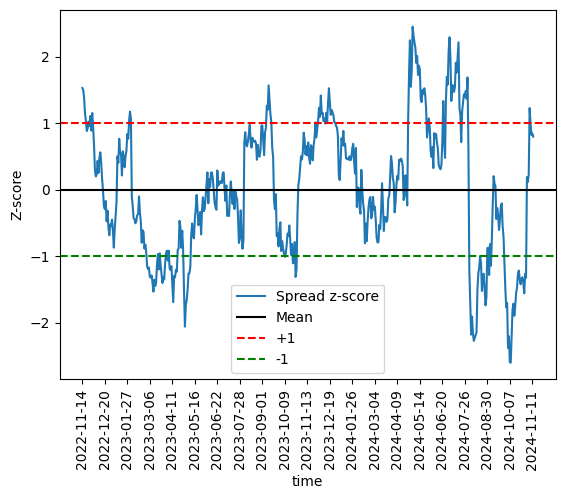

In [25]:
def zscore(series):
    return (series - series.mean()) / np.std(series)
z_score_spread= zscore(spread)
plt.plot(z_score_spread)
plt.axhline(z_score_spread.mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])
plt.xticks(selected_indices, selected_timestamps, rotation=90)  
plt.ylabel("Z-score")
plt.xlabel("time")


Now that the spread has been standardised, we can implement the conjecture that a long or short position should be opened if the z-score of the price is outwith the interval z<|1|.

An enhancement to this is calculating recent volatility of each individual stock and assessing its impact on the overall spread's diversion from mean.



In [26]:
#The below code has functions to calculate certain stats based on rolling windows

import numpy as np
import pandas as pd
from scipy import stats

def zscore(series):
    return (series - series.mean()) / series.std()

def rollingPercentagePriceChange(data, window: int = 20):
    data_series = pd.Series(data)
    return data_series.pct_change().dropna()

def rollingVolatility(data: list, window: int = 20):
    data_series = pd.Series(data)
    price_change = data_series.pct_change().dropna()
    rolling_volatility = price_change.rolling(window=window).std()
    return rolling_volatility.dropna()

def movingAverage(data: list, window: int = 20):
    data_series = pd.Series(data)
    return data_series.rolling(window=window).mean().dropna()

def standardiseMovingAverage(data: list, window: int = 20):
    ma_data = movingAverage(data, window)
    return zscore(ma_data)

def p_value_marginal(data: list, window: int = 20):
    data_series = pd.Series(data)
    ma_data = movingAverage(data_series, window)
    ma_mean = ma_data.mean()
    ma_std = ma_data.std()
    
    # Use z-scores calculated from rolling data directly
    z_score = (data_series - ma_mean) / ma_std
    p_values = 1 - (2 * stats.norm.cdf(abs(z_score)))
    p_values = pd.Series(p_values)
    return p_values.dropna()

def p_spread_reverts_based_on_marginal_probability_and_volatility(data_stock_A, data_stock_B, window: int = 20, marginal_volatility_sensitivity: float = 0.5):
    p_a = p_value_marginal(data_stock_A, window)
    p_b = p_value_marginal(data_stock_B, window)
    volatility_influence_a = marginal_volatility_sensitivity * rollingVolatility(data_stock_A, window)
    volatility_influence_b = marginal_volatility_sensitivity * rollingVolatility(data_stock_B, window)
    
    # Align data sizes before multiplying, to avoid broadcasting issues
    min_length = min(len(p_a), len(p_b), len(volatility_influence_a), len(volatility_influence_b))
    weighted_probability = (volatility_influence_a[:min_length] * p_a[:min_length] +
                            volatility_influence_b[:min_length] * p_b[:min_length])
    
    probability = 1 / (1 + np.exp(-weighted_probability))  # Apply sigmoid function
    return probability.dropna()

def p_spread_reverts(normalised_spread_data):
    return 2*(1- stats.norm.cdf(abs(normalised_spread_data)))




In [27]:

class order():
    def __init__(self,asset,type, enter_price,capital:int=100000,trade_size:int=1000, stop_loss:int=500, take_profit:int=1000):
        self.asset = asset
        self.type = type
        self.enter_price = enter_price
        self.trade_size = trade_size
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.capital = capital
        self.status = 'OPEN'
        self.final_profit = None

    def get_profit_loss_final(self):
        if self.exit_price is not None:
            profit_loss = ((self.exit_price - self.enter_price) / self.enter_price) * 100
            if self.type == 'SELL':
                profit_loss *= -1
            return profit_loss*self.trade_size
        return None
    
    def get_profit_loss_current_pct(self,current_price):
        current_profit_loss_pct = ((current_price-self.enter_price)/self.enter_price)*100
        if self.type == 'SELL':
            current_profit_loss_pct = current_profit_loss_pct*-1
        return current_profit_loss_pct
    
    def get_profit_loss_current(self,current_price):
        current_profit_loss = self.get_profit_loss_current_pct(current_price)*self.trade_size
        if self.type == 'SELL':
            current_profit_loss = current_profit_loss*-1
        return current_profit_loss
    
    def evaluatePosition(self,joint_prob:list, spread_revert_prob:list, prices_stock_A, prices_stock_B):
        pricelist = prices_stock_A if self.asset == 'Stock A' else prices_stock_B
        for i in range(len(pricelist)):
            if joint_prob[i]<0.5:
                self.exit_price = pricelist[i]
                self.final_profit= self.get_profit_loss_final()
                self.status = 'CLOSED'
                break
            elif spread_revert_prob[i]<0.5:
                self.exit_price = pricelist[i]
                self.final_profit= self.get_profit_loss_final()
                self.status = 'CLOSED'
                break
            elif self.get_profit_loss_current(pricelist[i])>=self.take_profit:
                self.exit_price = pricelist[i]
                self.final_profit= self.get_profit_loss_final()
                self.status = 'CLOSED'
                break
            elif self.get_profit_loss_current(pricelist[i])<= (self.stop_loss*-1):
                self.exit_price = pricelist[i]
                self.final_profit= self.get_profit_loss_final()
                self.status = 'CLOSED'
                break
            else:
                pass

    def __str__(self):
        return (f"Order(asset={self.asset}, type={self.type}, enter_price={self.enter_price}, "
                f"capital={self.capital}, stop_loss={self.stop_loss}, take_profit={self.take_profit}, "
                f"status={self.status}, final_profit={self.final_profit})")
        

def monitorOrders(orders,joint_prob, spread_revert_prob, prices_stock_A, prices_stock_B):
    for order in orders:
        if order == 'No Trade':
            pass
        else:
           order.evaluatePosition(joint_prob, spread_revert_prob, prices_stock_A,prices_stock_B)

# all input lists must be of the same length
def triggerOrders(orders:list, joint_prob:list, spread_revert_prob:list, stock_A_PPC:list, stock_B_PPC:list,prices_stock_A:list,prices_stock_B:list, capital: int=100000):  # PPC = percentage price change
    for i in range(len(joint_prob)):
        if (joint_prob[i] > 0.2) and (spread_revert_prob[i] > 0.2):
           if stock_A_PPC[i] > 0 and stock_B_PPC[i] < 0:
                orders.append(order('Stock A','SELL',prices_stock_A[i],capital))
                orders.append(order('Stock B','BUY',prices_stock_B[i],capital))
           elif stock_B_PPC[i] > 0 and stock_A_PPC[i] < 0:
                orders.append(order('Stock B','SELL',prices_stock_B[i],capital))
                orders.append(order('Stock A','BUY',prices_stock_A[i],capital))
           elif stock_A_PPC[i] > 0 and stock_B_PPC[i] >= 0 and stock_A_PPC[i] > stock_B_PPC[i]:
                orders.append(order('Stock A','SELL',prices_stock_A[i],capital))
           elif stock_B_PPC[i] > 0 and stock_A_PPC[i] >= 0 and stock_B_PPC[i] > stock_A_PPC[i]:
                orders.append(order('Stock B','SELL',prices_stock_B[i],capital))
           elif stock_A_PPC[i] < 0 and stock_B_PPC[i] <= 0 and stock_A_PPC[i] < stock_B_PPC[i]:
                orders.append(order('Stock A','BUY',prices_stock_A[i],capital))
           elif stock_B_PPC[i] < 0 and stock_A_PPC[i] <= 0 and stock_B_PPC[i] < stock_A_PPC[i]:
                orders.append(order('Stock B','BUY',prices_stock_B[i],capital))
        else:
            orders.append('No Trade' )
    
    monitorOrders(orders,joint_prob,spread_revert_prob,prices_stock_A,prices_stock_B)



def getTotalProfitLoss(orders:list):
    total=0
    for ordr in orders:
        if isinstance(ordr,order):
           total+=ordr.final_profit
    return total

In [28]:
# replace dropna() above with other methods that dont disrupt index wise calculations

lengths = [
    len(S1), len(S2), len(rollingPercentagePriceChange(S1)),
    len(rollingPercentagePriceChange(S2)), len(rollingVolatility(S1)),
    len(rollingVolatility(S2)), len(p_spread_reverts_based_on_marginal_probability_and_volatility(S1, S2)),
    len(p_spread_reverts(z_score_spread))
]
min_length = min(lengths)
config_df = {'Stock A timeseries': S1[:min_length],
             'Stock B timeseries': S2[:min_length],
             'Stock A price change %': rollingPercentagePriceChange(S1)[:min_length],
             'Stock B price change %': rollingPercentagePriceChange(S2)[:min_length],
             'Stock A volatility': rollingVolatility(S1)[:min_length],
             'Stock B volatility': rollingVolatility(S2)[:min_length],
             'Joint marginal probability': p_spread_reverts_based_on_marginal_probability_and_volatility(S1,S2)[:min_length],
             'Spread reverts probability': list(map(lambda x: float(x), p_spread_reverts(z_score_spread)[:min_length]))
             }

# resulting_stats = pd.DataFrame(config_df)

# print(config_df)
orders = []
CAPITAL = 100000
# triggerOrders(orders,
#               list(resulting_stats['Joint marginal probability']),
#               list(resulting_stats['Spread reverts probability']),
#               list(resulting_stats['Stock A price change %']),
#               list(resulting_stats['Stock B price change %']),
#               list(resulting_stats['Stock A timeseries']),
#               list(resulting_stats['Stock B timeseries']),
#               100000
#               )
triggerOrders(
    orders,
    list(config_df['Joint marginal probability']),
    list(config_df['Spread reverts probability']),
    list(config_df['Stock A price change %']),
    list(config_df['Stock B price change %']),
    list(config_df['Stock A timeseries']),
    list(config_df['Stock B timeseries']),
    CAPITAL
)
# for ordr in orders:
#     if isinstance(ordr,order):
#         print(ordr.__str__())
        
profit_value = float(getTotalProfitLoss(orders))
profit_pct = (profit_value/CAPITAL)*100

print("Portfolio size: ",CAPITAL)
print("Profit: ", profit_value)
print("Profit percentage: ", profit_pct, ' %')




Portfolio size:  100000
Profit:  1527983.0753412622
Profit percentage:  1527.983075341262  %
